# Meander generator using shapely

## Init

In [1]:
import shapely as sp
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon, GeometryCollection
from shapely.ops import linemerge, unary_union

import ezdxf as ez

import numpy as np

from IPython.display import display, SVG
from lxml import etree

from matplotlib import pyplot as plt
%matplotlib notebook

## Display

### SVG

In [2]:
def generate_svg_grid( x, y, w, h, d, D, dattrib={}, Dattrib={} ):
    """
    Generates SVG grid pattern
    
    x, y: coordinates to center grid on
    w, h: width and height of grid
    d, D: step size of minor/major grid
    dattrib, Dattrib: attributes to pass to minor/major grid
    """
    
    grid_svg = etree.XML(f"""
    <g>
        <defs>
            <pattern id="smallGrid" width="{d}" height="{d}" patternUnits="userSpaceOnUse">
                <path id="minorSquare" d="M {d} 0 L 0 0 0 {d}" fill="none" stroke="gray" stroke-width="0.05"/>
            </pattern>
            <pattern id="grid" width="{D}" height="{D}" patternUnits="userSpaceOnUse">
                <rect width="{D}" height="{D}" fill="url(#smallGrid)"/>
                <path id="majorSquare" d="M {D} 0 L 0 0 0 {D}" fill="none" stroke="blue" stroke-width=".1"/>
            </pattern>
        </defs>
        <rect x="{x}" y="{y}" width="{w}" height="{h}" fill="url(#grid)" />
    </g>
    """)
    for k in dattrib.keys():
        grid_svg.xpath("//path[@id='minorSquare']")[0].attrib[k] = dattrib[k]
    for k in Dattrib.keys():
        grid_svg.xpath("//path[@id='majorSquare']")[0].attrib[k] = Dattrib[k]
    return( grid_svg )

In [3]:
def nice_svg( e, attribs={"stroke-width":"0"} ):
    """
    Create nice svg path from shapely element e.
    
    attribs: attributes to be overvriten/given
    """
    
    svg = etree.XML( e.svg() )
    for k in attribs.keys():
        svg.attrib[k] = attribs[k]
    return( svg )

In [4]:
def display_svg( elements, bounds ):
    """
    Display collection as an SVG
    """
    
    x1,y1,x2,y2 = bounds
    svg_root = etree.XML(f"""
    <svg viewbox='{x1} {y1} {x2-x1} {y2-y1}' >
    </svg>
    """)
    for e in elements:
        svg_root.append( e )
    display(SVG(etree.tostring(svg_root)))
    

### Matplotlib

In [5]:
def shapely_display_poly( poly, ax, fillkwargs={}, dotkwargs={} ):
    assert( type(poly) == Polygon )
    x, y = poly.exterior.xy
    ax.fill( x, y, **fillkwargs )
    ax.plot(x,y,".",**dotkwargs)

def shapely_display_line( line, ax, pltkwargs={} ):
    assert( type(line) == LineString )
    x, y = line.xy
    ax.plot(x,y,".-",**pltkwargs)

def shapely_display_multiline( mline, ax, pltkwargs={}):
    for line in mline:
        shapely_display_line( line, ax, pltkwargs )

## Shape generators

In [6]:
def circle_segment( P, r, a1=0, a2=np.pi, d=10 ):
    """
    Generate cricle segment
    
    P: center of circel
    r: radius
    a1, a2: start/stop angles
    d: number of segments
    """
    angles = np.linspace( a1, a2, d )
    x = np.sin( angles )*r + P.x
    y = np.cos( angles )*r + P.y
    return( zip( x, y ) )

def box( p, a, b ):
    """
    Draw a box
    
    a: width
    b: height
    """

    return( Polygon([
        [p.x-a/2,p.y-b/2],
        [p.x-a/2,p.y+b/2],
        [p.x+a/2,p.y+b/2],
        [p.x+a/2,p.y-b/2],
    ]))


def square( p, a ):
    """
    Draw square
    
    p: center of square
    a: side length
    """
    
    return( box(p,a,a) )

def basic_meander_line( l, r, n, d=10 ):
    """
    Very basic meander line
    
    l: length of straight lines
    r: radius bends
    n: straights total
    """
    lines = [ [[0,i*2*r],[l,i*2*r]][::(1-i%2*2)] for i in range(n) ]
    circles = [ circle_segment(
            Point([l*((i+1)%2),(i*2+1)*r]),
            r,
            np.pi*(1-i%2*2),
            0,
            d=d) for i in range(n-1) ]
    meander = []
    for i in range(n-1):
        meander.extend( lines[i] )
        meander.extend( circles[i] )
    meander.extend( lines[n-1] )
    return( LineString(meander) )

def line_to_cpwg( line, s, w ):
    """
    Generate two ditches of CPWG along the given line(s)
    
    s, w: CPWG parameters
    """

    left_line = line.parallel_offset( (s+w)/2, "left", resolution=1 )
    right_line = line.parallel_offset( (s+w)/2, "right", resolution=1 )
    left_ditch = left_line.buffer( w/2, cap_style=2, resolution=1, )
    right_ditch = right_line.buffer( w/2, cap_style=2, resolution=1 )
    return( (left_ditch, right_ditch, line, left_line, right_line) )
    
def basic_meander( l, r, n, s, w, d=10 ):
    """
    Very basic meander CPWG
    Can't use line_to_cpwg, strange bug with parallel_offset
    
    s, w: CPWG parameters
    l: length of straight lines
    r: radius bends
    n: straights total
    """
    
    line = basic_meander_line( l, r, n, d )
    left_line = line.parallel_offset( (s+w)/2, "left", resolution=1 )
    right_line = line.parallel_offset( (s+w)/2, "right", resolution=1 )
    if n%2 == 0: # wierd shapely bug
        right_line = LineString( right_line.coords[1:-1] ) #
    left_ditch = left_line.buffer( w/2, cap_style=2, resolution=1, )
    right_ditch = right_line.buffer( w/2, cap_style=2, resolution=1 )
    return( (left_ditch, right_ditch, line, left_line, right_line) )

### Launcher

In [7]:
def launcher( s, w, a, b, c, g ):
    """
    Generate rectangular launcher
    
    s, w: CPWG parameters of line to connect to
    a, b: width, height of launcher
    c: lengt of transitional triangle
    g: gap around launcher 
    """
    
    outer_launcher = box( Point(c+a/2+g/2,0), a+g, b+2*g )
    inner_launcher = box( Point(c+a/2,0), a, b )
    outer_trans = Polygon( [[0,s/2+w],[c,b/2+g],[c,-b/2-g],[0,-s/2-w]])
    inner_trans = Polygon( [[0,s/2],[c,b/2],[c,-b/2],[0,-s/2]])
    inside = unary_union( [inner_trans, inner_launcher] )
    outside = unary_union( [outer_trans, outer_launcher] )
    launcher = outside.difference( inside )
    return( launcher, inside, outside )


### Simple meander test

In [257]:
l,r,m,ll,rl = basic_meander( 6, 1.5, 5, .3, .3, 20 )
launch, ins, out = launcher(.3, .3, 6, 5, 3, 1.5)
launch = sp.affinity.rotate( launch, angle=180, origin=(0,0) )
display_svg(
    (
        nice_svg(l,attribs={"fill":"#00ff00", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(r,attribs={"fill":"#ff0000", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(launch,attribs={"fill":"#ffaaff", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(m,attribs={"stroke-width":".1"}),
        nice_svg(rl,attribs={"stroke-width":".1"}),
        nice_svg(ll,attribs={"stroke-width":".1"}),
        
        generate_svg_grid(-3,-3,30,30,.3,3)
    ),
    m.union(launch).buffer(1).bounds
)

## Patterning

In [9]:
def generate_dots_sq( r, d, bounding_box ):
    """
    Generate square lattice of round dots
    
    r: radius of single dot
    d: distance of dots
    bounding_box: x1,y1,x2,y2 of box to generate dots in
    """
    
    x1,y1,x2,y2 = bounding_box
    nx = (x2-x1)/d
    ny = (y2-y1)/d
    dots = []
    for x in range( int(nx)+1 ):
        for y in range( int(ny)+1 ):
            dots.append( Polygon(circle_segment(Point(x*d+x1,y*d+y1),r,a1=0, a2=np.pi*2 ) ) )
    return( dots )

def generate_dots_tri( r, d, bounding_box ):
    """
    Generate hex lattice of round dots
    
    r: radius of single dot
    d: distance of dots
    bounding_box: x1,y1,x2,y2 of box to generate dots in
    """
    
    x1,y1,x2,y2 = bounding_box
    nx = (x2-x1)/d
    ny = (y2-y1)/d*np.sqrt(2)
    dots = []
    for x in range( int(nx)+1 ):
        for y in range( int(ny)+1 ):
            dots.append(Polygon(circle_segment(
                Point((x+y%2/2)*d+x1,y*d/np.sqrt(2)+y1)
                ,r,0,np.pi*2)))
    return( dots )

def generate_squares( a, d, bounding_box ):
    """
    Generate square pattern
    
    a: side length of squares
    d: distance between squares
    bounding_box: x1,y1,x2,y2 bounds of area to generate pattern in
    """
    
    x1,y1,x2,y2 = bounding_box
    nx = (x2-x1)/d
    ny = (y2-y1)/d
    squares = []
    for x in range( int(nx)+1 ):
        for y in range( int(ny)+1 ):
            squares.append( Polygon( square(Point((x+y%2/2)*d+x1,y*d+y1),a)))
    return( squares )

In [10]:
l,r,m,ll,rl = basic_meander( 6, 1.5, 4, .3, .3, 20 )
end_cap = box( Point(0,0), .3, .9 )
near = m.buffer(1)
edges = unary_union( [r, l, end_cap] )
dots = generate_dots_tri( .03, .09, near.bounds )
dots_good = [ d for d in dots if near.contains(d) and edges.distance(d) > .02]
squares = generate_squares( .5, .6, near.buffer(2).bounds )
for i in range(len(squares)):
    squares[i] = squares[i].difference( near.buffer(.05) )
display_svg(
    (
        #nice_svg(l,attribs={"fill":"#77f", "fill-opacity":"1", "stroke-width":"0"}),
        #nice_svg(r,attribs={"fill":"#7f7", "fill-opacity":"1", "stroke-width":"0"}),
        #nice_svg(end_cap,attribs={"fill":"#f77", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(edges,attribs={"fill":"#fff", "fill-opacity":".7", "stroke-width":"0"}),
        #nice_svg(m,attribs={"stroke-width":".1"}),
        #generate_svg_grid(-3,-3,30,30,.3,3),
        *[nice_svg(d) for d in dots_good],
        *[nice_svg(sq) for sq in squares],
    ),
    m.buffer(1.2).bounds
)


## DXF output

In [11]:
def poly_to_dxf( polys, doc):

    for i in range(len(polys)):
        x, y = polys[i].exterior.xy
        x_y = list(zip(x, y))
        x_y.append( [x[0], y[0]] )
        msp = doc.modelspace()
        msp.add_lwpolyline(x_y)

    return msp

    """
    Add a shapely Polygon to the model space of a dxf document
    """
    
    

In [12]:
line = LineString([Point( 0 , 0 ), Point( 600 , 0 )])
l, r, m, ll, rl = line_to_cpwg( line  , 15. , 5. )

launch, ins, out = launcher( 15. , 5. , 250. , 240. , 205. , 60 )
launch = sp.affinity.rotate( launch, angle=180, origin=(0,0) )

launch2, ins, out = launcher( 15. , 5. , 250. , 240. , 205. , 60 )
launch2 =  sp.affinity.translate( launch2, xoff = 600)

line_res = LineString([Point( 133 , 29.932 ), Point( 421.802 , 29.932 )])
l_res, r_res, m_res, ll_res, rl_res = line_to_cpwg( line_res  , 15. , 5. )

line_res2 = LineString([Point( 52.5 , 110.432 ), Point( 52.5 , 390.432 )])
l_res2, r_res2, m_res2, ll_res2, rl_res2 = line_to_cpwg( line_res2  , 15. , 5. )

box_res = box( Point(433.302 , 29.932), 23, 27)

centre = Point(133.,110.432)
circ = LineString(circle_segment(centre, 80.5, np.pi*0.995, np.pi*1.505, 20))
r_circ, l_circ, m_circ, rl_circ, ll_circ = line_to_cpwg( circ  , 15. , 5. )

l_meand,r_meand,m_meand,ll_meand,rl_meand = basic_meander( 552.82, 155, 4, 15, 5, d=20 )

l_meand = sp.affinity.scale(l_meand, xfact=-1.0, yfact=1.0, zfact=1.0, origin=(0,0))
l_meand = sp.affinity.rotate( l_meand, angle=270, origin=(0,0) )
l_meand =  sp.affinity.translate( l_meand, xoff = 52.5, yoff = 390.432)


r_meand = sp.affinity.scale(r_meand, xfact=-1.0, yfact=1.0, zfact=1.0, origin=(0,0))
r_meand = sp.affinity.rotate( r_meand, angle=270, origin=(0,0) )
r_meand =  sp.affinity.translate( r_meand, xoff = 52.5, yoff = 390.432)

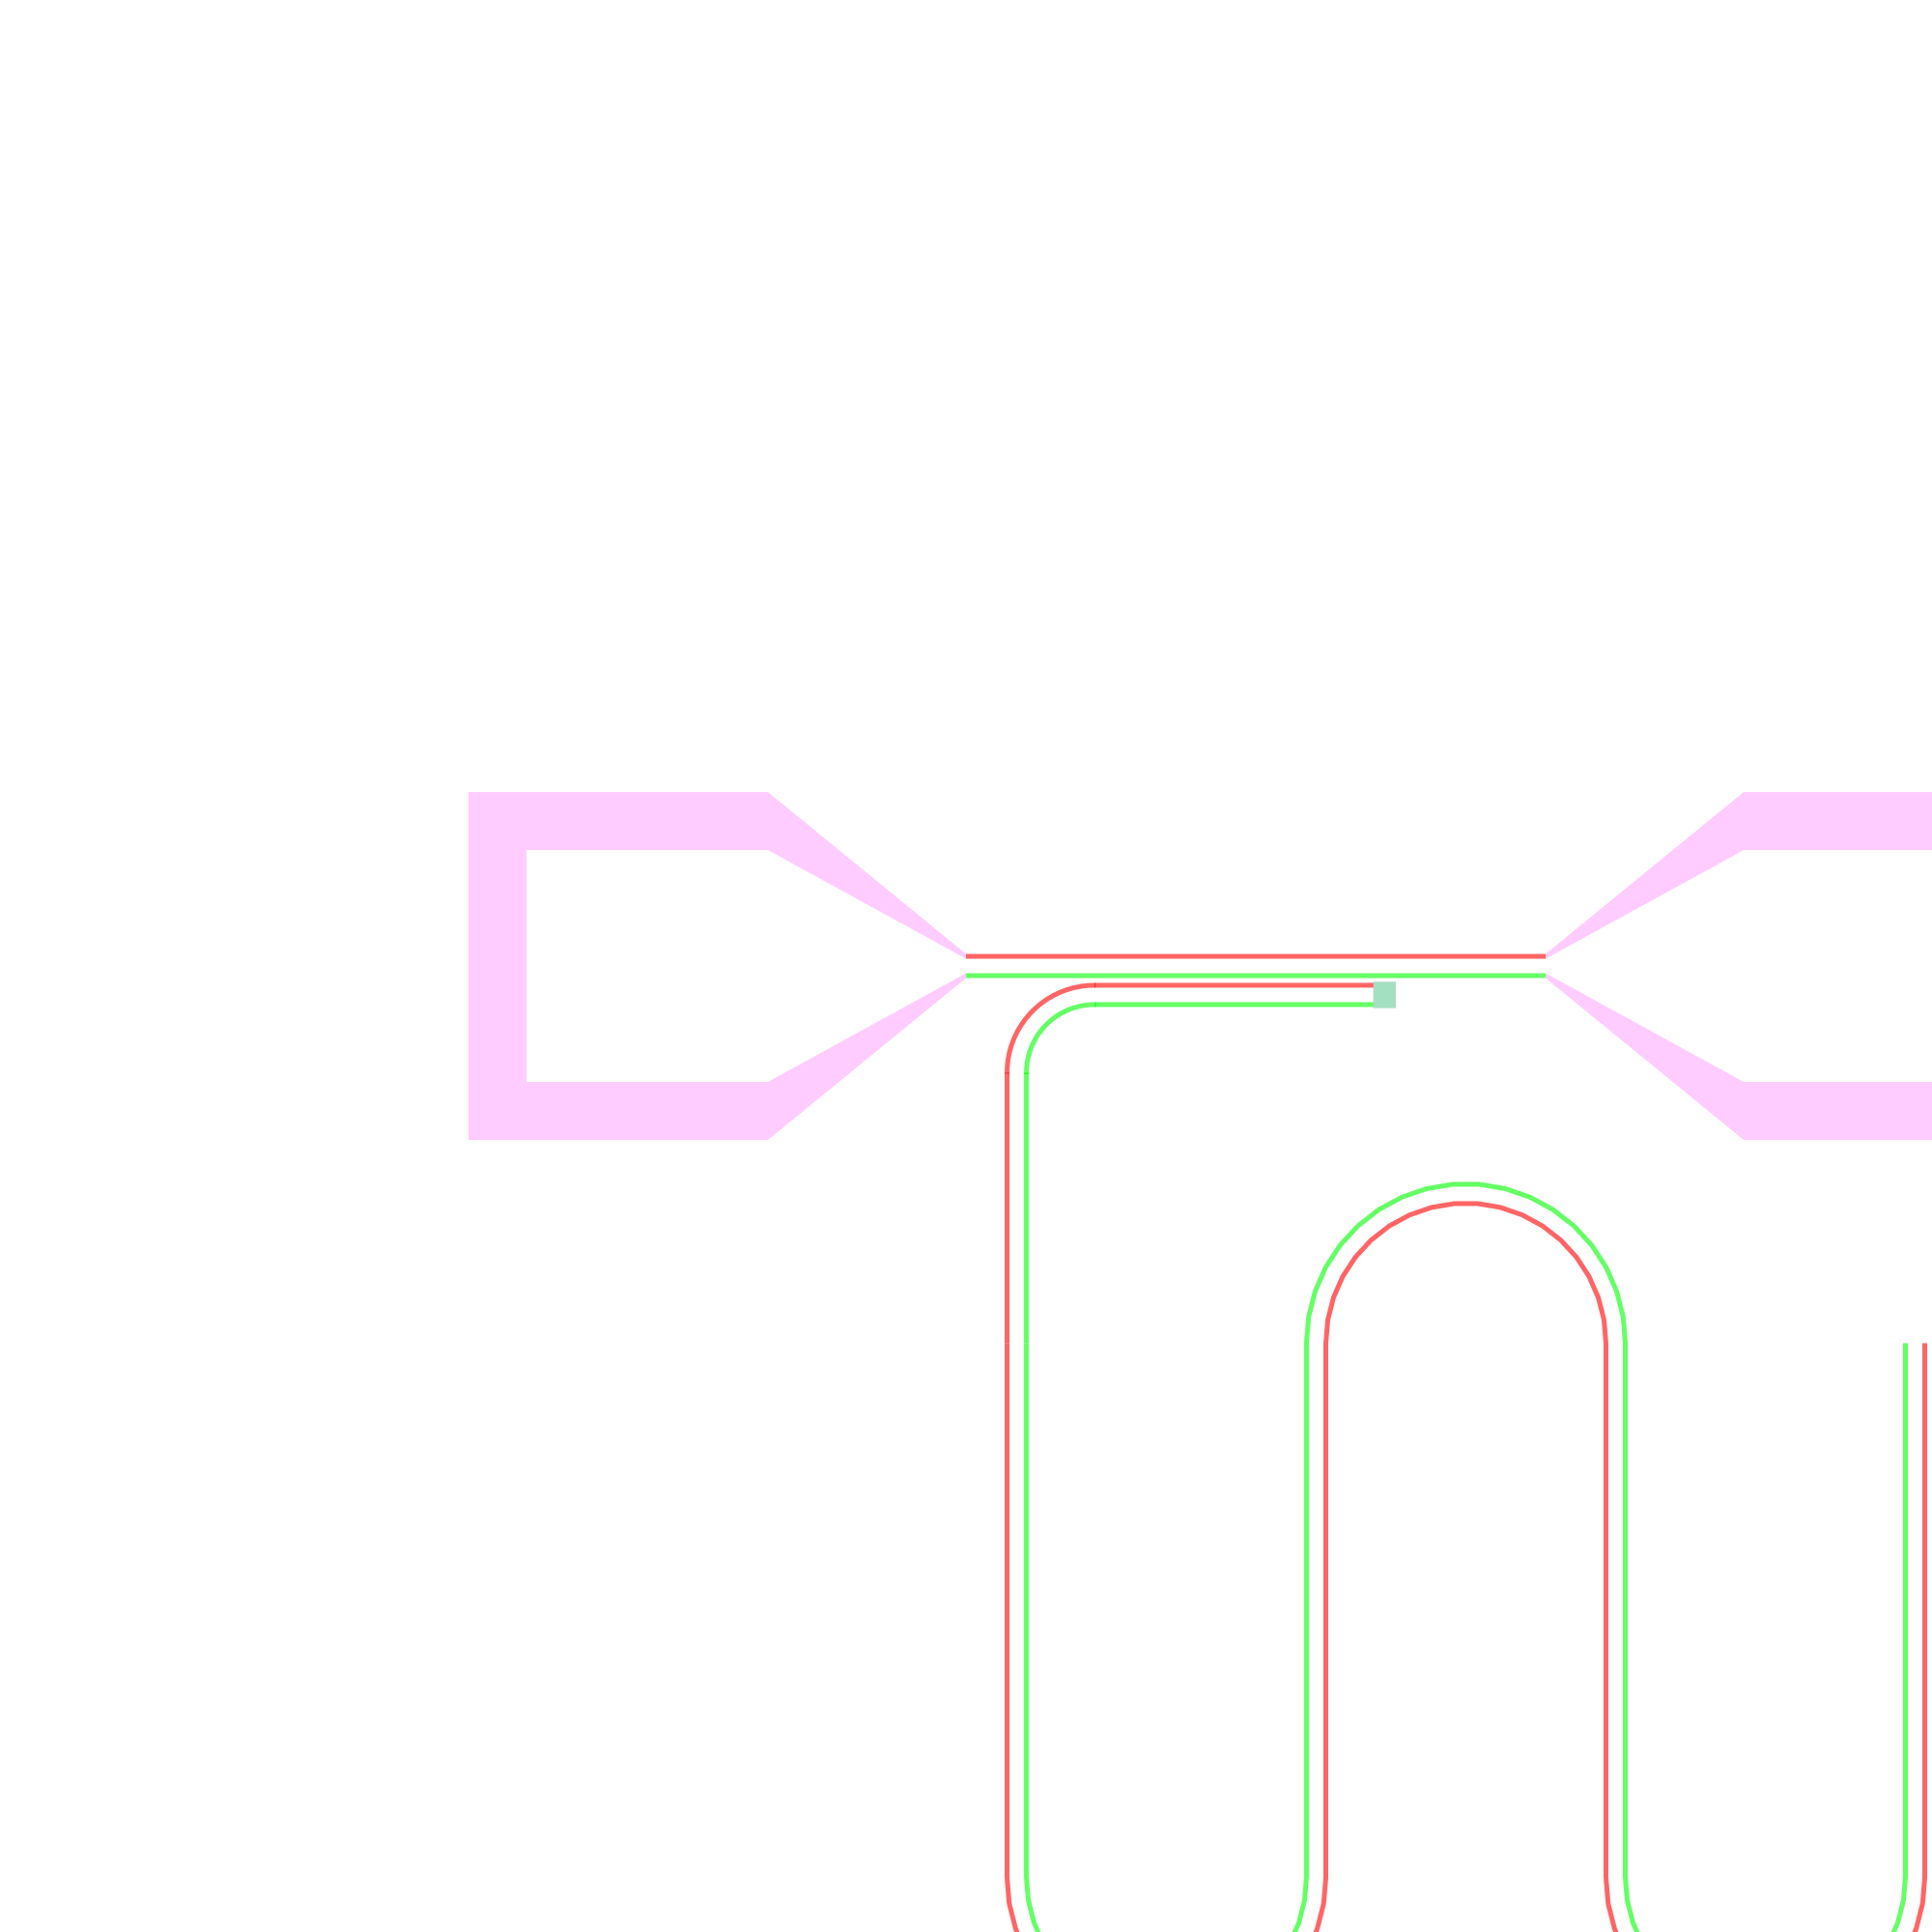

In [13]:
display_svg(
    (
        nice_svg(l,attribs={"fill":"#00ff00", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(r,attribs={"fill":"#ff0000", "fill-opacity":"1", "stroke-width":"0"}),

        nice_svg(l_circ,attribs={"fill":"#00ff00", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(r_circ,attribs={"fill":"#ff0000", "fill-opacity":"1", "stroke-width":"0"}),
        
        nice_svg(l_res,attribs={"fill":"#00ff00", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(r_res,attribs={"fill":"#ff0000", "fill-opacity":"1", "stroke-width":"0"}),
        
        nice_svg(r_res2,attribs={"fill":"#00ff00", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(l_res2,attribs={"fill":"#ff0000", "fill-opacity":"1", "stroke-width":"0"}),

        nice_svg(l_meand,attribs={"fill":"#00ff00", "fill-opacity":"1", "stroke-width":"0"}),
        nice_svg(r_meand,attribs={"fill":"#ff0000", "fill-opacity":"1", "stroke-width":"0"}),
        
        nice_svg(launch,attribs={"fill":"#ffaaff", "fill-opacity":"1", "stroke-width":"0"}),
        
        nice_svg(launch2,attribs={"fill":"#ffaaff", "fill-opacity":"1", "stroke-width":"0"}),
        


        
        nice_svg(box_res,attribs={"stroke-width":".1"}),
        
    ),
    (-500,-500,1500,1500)
)

In [14]:
doc = ez.new()
poly_to_dxf([l, r, launch, launch2, l_circ, r_circ, l_res, r_res, r_res2, l_res2, l_meand, r_meand], doc)
doc.saveas("meand.dxf")

## Design for 20200729

In [258]:
s = 15. #cpwg s
w = 5. #cpwg w
launcher_width = 240. #launcher bondingpad size
launcher_transition = 200. #launcher triangle length
launcher_gap = 60. #gap around bonding pad of launcher
margin = 50. #empty region around edge of WF
WF = 2000. #WF size
hanger_length = 420. #length of hanger piece parallel to feedline
coupling_dist = 3. #distance of hanger from feedline
hanger_offset = 90. #offset of hanger from launcher
hanger_endcap = 23. #length of ditch at open end of resonator
meander_r = 75. #meander radius
L = 7*700+1000+420+4*2*75*np.pi #approx full length of resonator
inlauncher_width = 80 # width on inlauncher triangle base
inlauncher_length = 100 #length of inlauncher triangle
inlauncher_gap = inlauncher_width/2 #gap around inlauncher
inlauncher_leggap = 3 #width of legs on inlauncher
samplespaceA = inlauncher_width+inlauncher_gap*3 #width of samplespace
samplespaceB = 300 #length of samplespace

launchL, _, _ = launcher( s, w , launcher_width, launcher_width , launcher_transition, launcher_gap )
launchR = sp.affinity.rotate(
    launcher( s, w , launcher_width, launcher_width , launcher_transition, launcher_gap )[0]
    , angle=180, origin=(0,0)
)
b = launchL.bounds
lw = b[2] - b[0]
lh = b[3] - b[1]
launchL = sp.affinity.translate( launchL, WF-margin-b[2] , lh/2+margin )
launchR = sp.affinity.translate( launchR, lw+margin, lh/2+margin ) #pull in, 50 away from edge

feed_line = LineString(
    ((lw+margin,lh/2+margin),
     (WF-margin-lw,lh/2+margin))
)
feed_lineL, feed_lineR, _, _, _ = line_to_cpwg( feed_line, s, w )

hanger_start = (lw+margin+hanger_offset,lh/2+margin+s+w*2+coupling_dist)
hanger_end = (lw+margin+hanger_offset+hanger_length,lh/2+margin+s+w*2+coupling_dist)
hanger_line = LineString( ( hanger_start, hanger_end ) )
hanger_lineL, hanger_lineR, _, _, _ = line_to_cpwg( hanger_line, s, w )
hanger_endcap = box(sp.affinity.translate(Point(hanger_end),hanger_endcap/2,0), hanger_endcap, s+2*w)

connector_line = LineString( circle_segment(
    sp.affinity.translate(Point(hanger_start),0,meander_r),
    meander_r, np.pi, np.pi*1.5, 50
) )
connectorL, connectorR, _, _, _ = line_to_cpwg( connector_line, s, w )

straight_length = 2000-connectorL.bounds[3]-margin-meander_r*2
circle_length = meander_r*np.pi
meanders = int((L-hanger_line.length-connector_line.length)/(straight_length+circle_length))
meanderL, meanderR, meander_line, _, _ = basic_meander( straight_length, meander_r, meanders, s, w, d=20 )
meander_line = sp.affinity.rotate( meander_line, 90, (0,0) )
meander_line = sp.affinity.translate( meander_line, *connector_line.coords[-1] )
meander_line = sp.affinity.translate( meander_line, (meanders-1)*2*meander_r, meander_r )
meanderL = sp.affinity.translate(
             sp.affinity.translate(
               sp.affinity.rotate(
                   meanderL, 90, (0,0)
               ), *connector_line.coords[-1]),
             (meanders-1)*2*meander_r, meander_r
)
meanderR = sp.affinity.translate(
             sp.affinity.translate(
               sp.affinity.rotate(
                   meanderR, 90, (0,0)
               ), *connector_line.coords[-1]),
             (meanders-1)*2*meander_r, meander_r
)

connectors_line = LineString( (connector_line.coords[-1],meander_line.coords[-1]) )
connectorsL, connectorsR, _, _, _ = line_to_cpwg( connectors_line, s, w )

connect_out_line = LineString( circle_segment(
    sp.affinity.translate( Point(meander_line.coords[0]), meander_r, 0 ),
    meander_r, np.pi/2, np.pi*1.5, 50
    ))
connect_outL, connect_outR, _, connect_out_lineL, connect_out_lineR = line_to_cpwg( connect_out_line, s, w )

inlauncherL = sp.affinity.translate(Polygon([
    [-w/2,0],
    [w/2,0],
    [inlauncher_gap+inlauncher_width/2-s/2-w/2,inlauncher_length],
    [inlauncher_width/2-s/2-w/2,inlauncher_length]
]),*connect_out_lineL.coords[0])

inlauncherR = sp.affinity.translate(Polygon([
    [w/2,0],
    [-w/2,0],
    [-(inlauncher_gap+inlauncher_width/2-s/2-w/2),inlauncher_length],
    [-(inlauncher_width/2-s/2-w/2),inlauncher_length]
]),*connect_out_lineR.coords[-1])

samplespace = box(
    sp.affinity.translate(Point(connect_out_line.coords[0]),
                          0,inlauncher_length+inlauncher_leggap+samplespaceB/2),
    samplespaceA, samplespaceB )

ssb = samplespace.bounds
launchG1 = sp.affinity.translate( launchL, 0, lh+margin )
lgb = launchG1.bounds
gate1_line = LineString((
    (ssb[2],lgb[1]/2+lgb[3]/2),
    (lgb[0],lgb[1]/2+lgb[3]/2)
))
gate1R, gate1L, _, _, _ = line_to_cpwg( gate1_line, s, w )

launchG2 = sp.affinity.translate( launchG1, 0, lh+margin )
lgb = launchG2.bounds
gate2_line = LineString((
    (ssb[0]/2+ssb[2]/2,ssb[3]),
    (ssb[0]/2+ssb[2]/2,lgb[1]/2+lgb[3]/2),
    (ssb[2],lgb[1]/2+lgb[3]/2),
    (lgb[0],lgb[1]/2+lgb[3]/2)
))
gate2R, gate2L, _, _, _ = line_to_cpwg( gate2_line, s, w )

feedline_mp = MultiPolygon( [launchL, launchR, feed_lineL, feed_lineR] )
resonator_mp = MultiPolygon( [
    hanger_endcap, hanger_lineL, hanger_lineR,
    connectorL, connectorR, connectorsL, connectorsR,
    meanderL, meanderR, connect_outR, connect_outL,
    inlauncherL, inlauncherR
])
RF_parts = MultiPolygon( [*resonator_mp.geoms, *feedline_mp.geoms]  )
gate1_mp = MultiPolygon([launchG1, gate1L, gate1R])
gate2_mp = MultiPolygon([launchG2, gate2L, gate2R])
all_elements = MultiPolygon([
    launchL.convex_hull, launchR.convex_hull, feed_lineL, feed_lineR,
    hanger_endcap, hanger_lineL, hanger_lineR,
    connectorL, connectorR, connectorsL, connectorsR,
    meanderL, meanderR, connect_outR, connect_outL,
    inlauncherL, inlauncherR,
    launchG1.convex_hull, gate1L, gate1R,
    launchG2.convex_hull, gate2L, gate2R,
    samplespace
])

squares = generate_squares( 15, 20, all_elements.buffer(10).bounds )
for i in range(len(squares)):
    squares[i] = squares[i].difference( all_elements.buffer(s+w/3) )
squares = [ sq for sq in squares
           if (sq.area > 15*15/3) and (sq.distance(RF_parts) < 100) ]


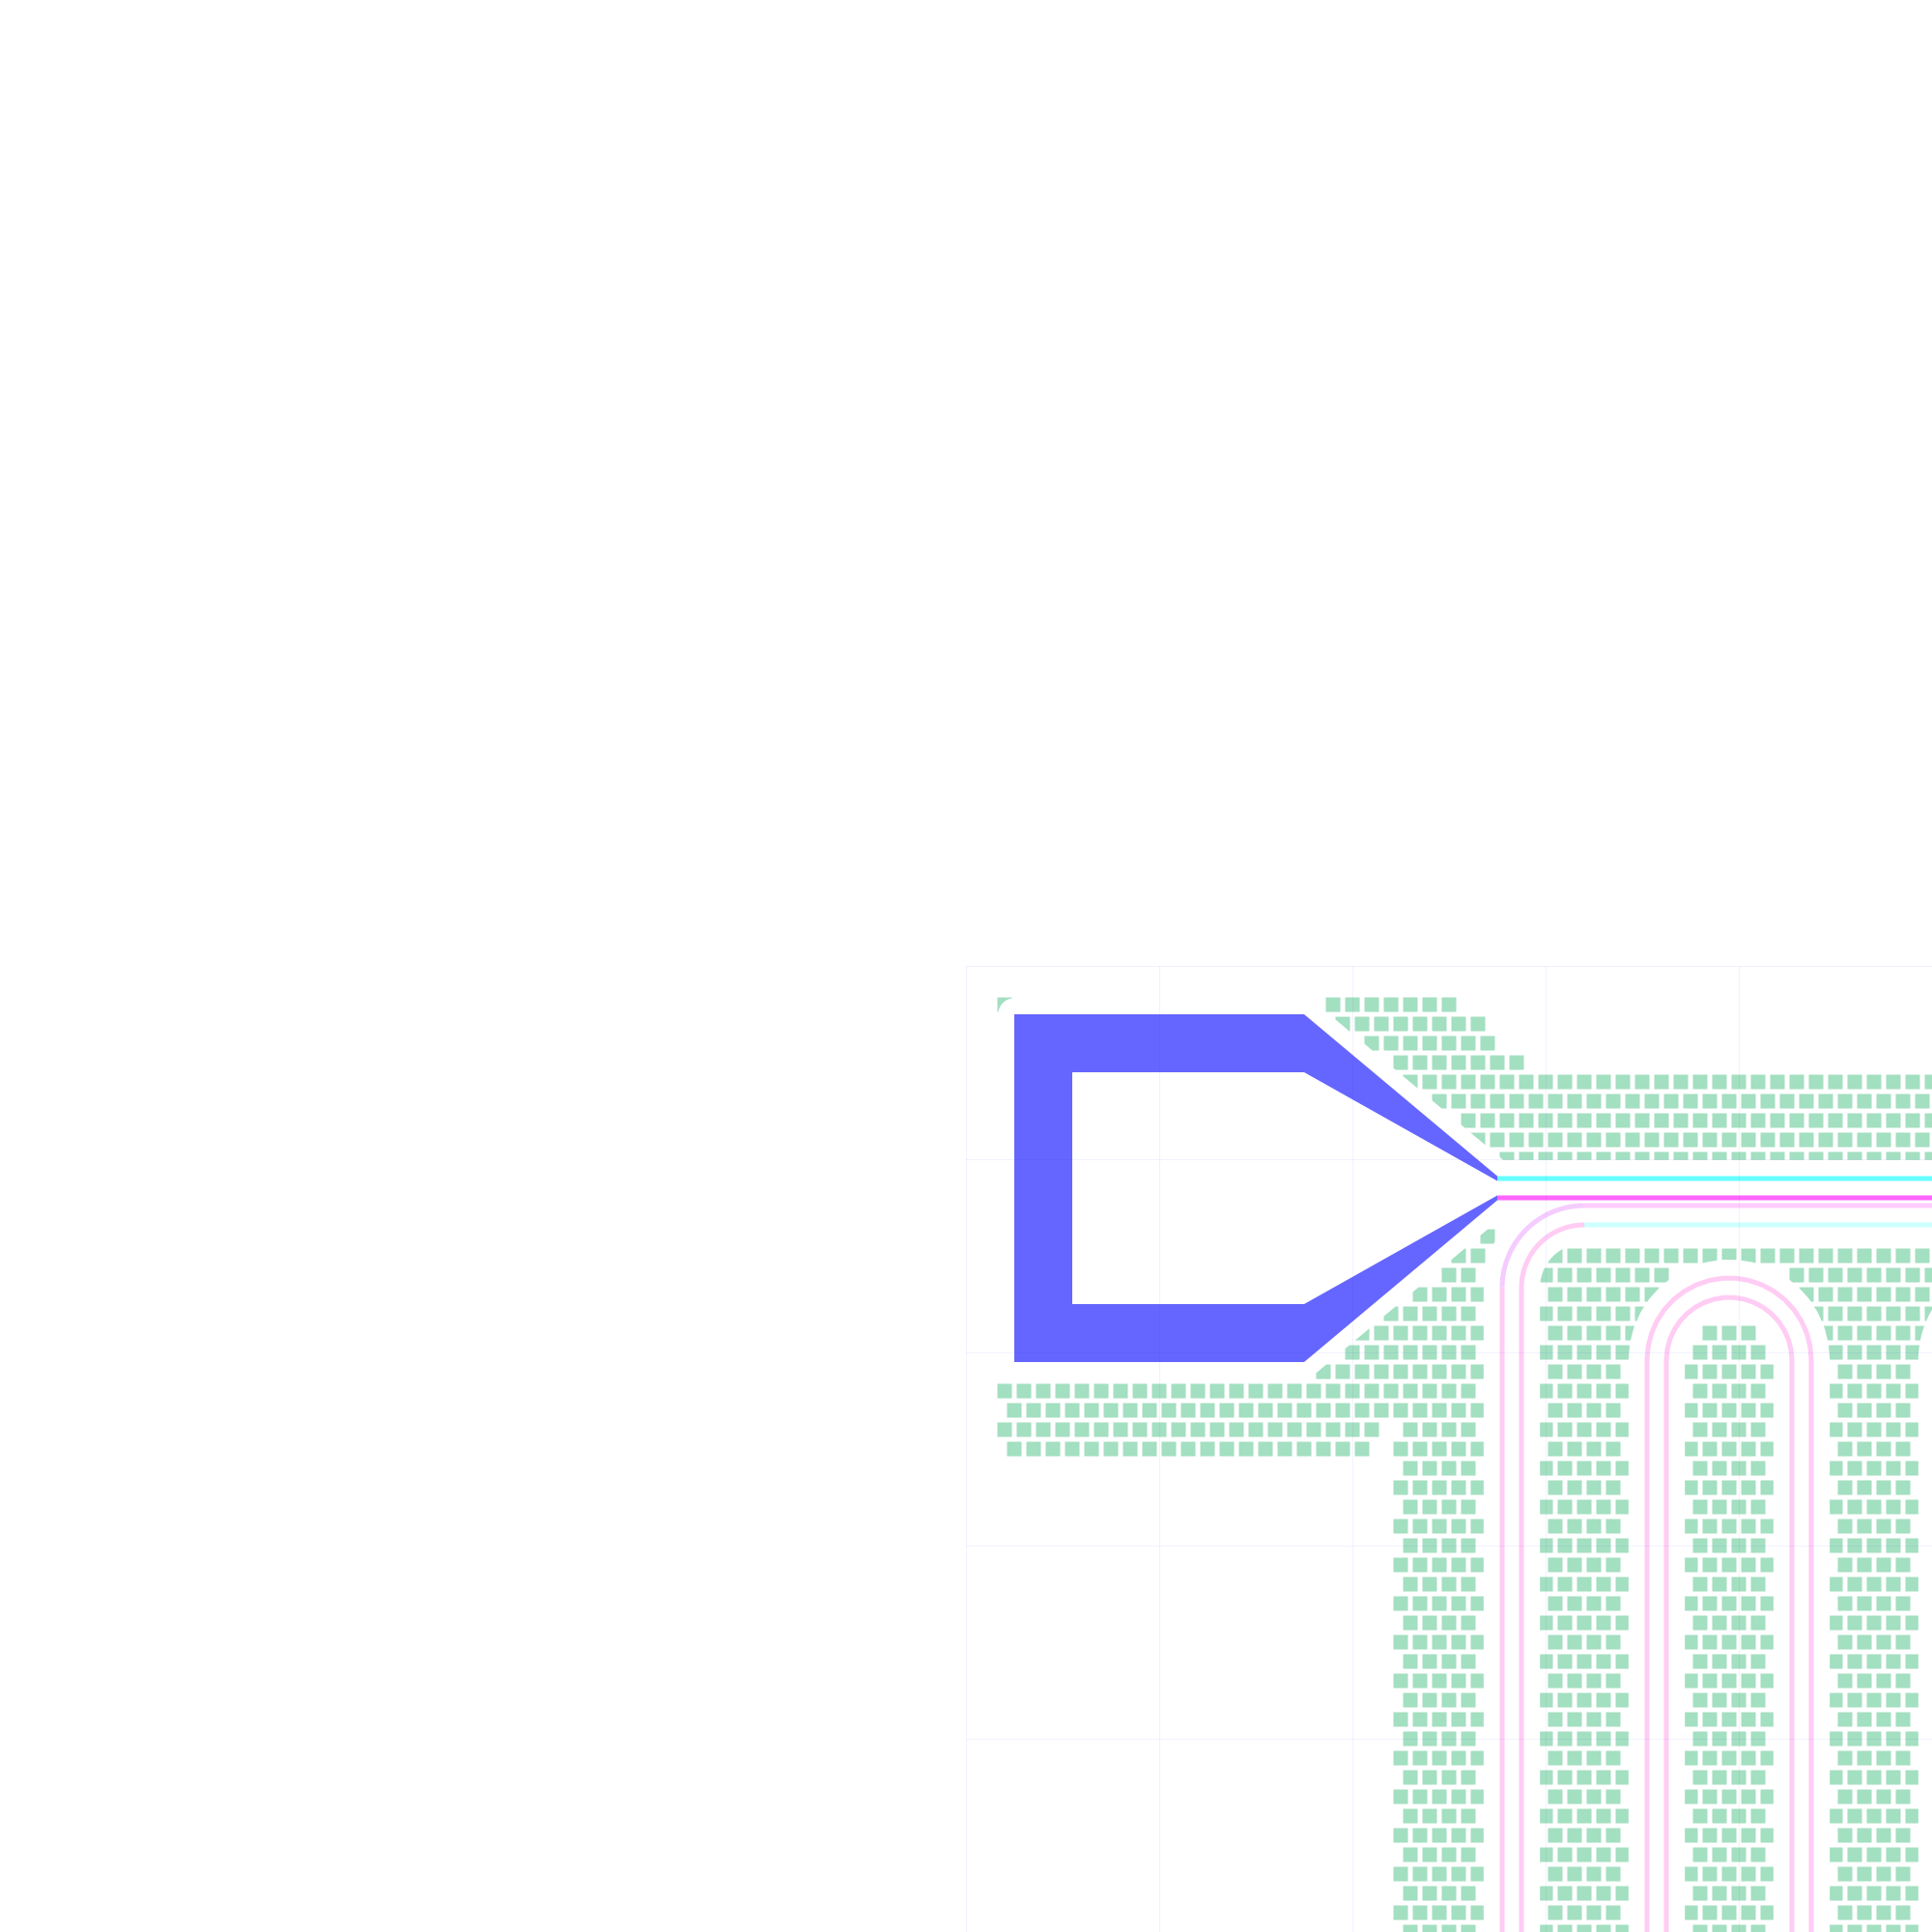

In [249]:
display_svg(
    
    (
        nice_svg(
            launchL,
            attribs={"fill":"#00ff00", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            launchR,
            attribs={"fill":"#0000ff", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            feed_lineL,
            attribs={"fill":"#ff00ff", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            feed_lineR,
            attribs={"fill":"#00ffff", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            hanger_lineL,
            attribs={"fill":"#aaffff", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            hanger_lineR,
            attribs={"fill":"#ffaaff", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            hanger_endcap,
            attribs={"fill":"#ffaaff", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            connectorL,
            attribs={"fill":"#eeaaff", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            connectorR,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            meanderR,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            meanderL,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            connectorsR,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            connectorsL,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            connect_outR,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            connect_outL,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            inlauncherL,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            inlauncherR,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            samplespace,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            launchG1,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            launchG2,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            gate1R,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            gate1L,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            gate2R,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        nice_svg(
            gate2L,
            attribs={"fill":"#ffaaee", "fill-opacity":"1", "stroke-width":"0"}
        ),
        *[nice_svg(sq) for sq in squares],
        
        generate_svg_grid(0,0,2000,2000,100,200)
     ),
    (0,0,2000,2000)
)

In [239]:
def poly_to_dxf( polys, doc):

    for p in polys:
        try:
            x, y = p.exterior.xy
        except:
            p
        x_y = list(zip(x, y))
        x_y.append( [x[0], y[0]] )
        msp = doc.modelspace()
        msp.add_lwpolyline(x_y)

In [242]:
doc = ez.new()
poly_to_dxf([
    launchL, launchR, feed_lineL, feed_lineR,
    hanger_endcap, hanger_lineL, hanger_lineR,
    connectorL, connectorR, connectorsL, connectorsR,
    meanderL, meanderR, connect_outR, connect_outL,
    inlauncherL, inlauncherR,
    launchG1, gate1L, gate1R,
    launchG2, gate2L, gate2R,
    samplespace
]+squares, doc)
doc.saveas("Meander1.1.1.dxf")

In [235]:
[type(i) for i in [
    launchL, launchR, feed_lineL, feed_lineR,
    hanger_endcap, hanger_lineL, hanger_lineR,
    connectorL, connectorR, connectorsL, connectorsR,
    meanderL, meanderR, connect_outR, connect_outL,
    inlauncherL, inlauncherR,
    launchG1, gate1L, gate1R,
    launchG2, gate2L, gate2R,
    samplespace
]+squares if type(i) is not sp.geometry.polygon.Polygon ]

[]